In [1]:
import os
import socket
from timeit import default_timer as timer
from glob import glob
import pandas as pd
import pyarrow.parquet as pq

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
country_code = "MX"
print('Country:', country_code)

Country: MX


In [3]:
# Local
print('Hostname:', socket.gethostname())
if  'samuel' in socket.gethostname().lower():
    path_to_data='../../data'
# Cluster
else:
    path_to_data='/scratch/spf248/twitter/data'
    
path_to_mentions=os.path.join(path_to_data,'mentions')
path_to_official_data=os.path.join(path_to_data,'official')
print(path_to_mentions)
print(path_to_official_data)

Hostname: Samuels-MBP
../../data/mentions
../../data/official


# Twitter Labor Market Indicators

In [4]:
print('Import Mentions Counts')
start = timer()

mentions=pq.ParquetDataset(glob(os.path.join(path_to_mentions,'series',country_code,'*.parquet'))).read().to_pandas()
counts=pq.ParquetDataset(glob(os.path.join(path_to_mentions,'counts',country_code,'*.parquet'))).read().to_pandas()
print('# obs:', mentions.shape[0])

print("Done in", round(timer()-start), "sec")

Import Mentions Counts
# obs: 1224626
Done in 1 sec


In [5]:
counts.sort_values(by=['wordlist','count'],ascending=[True,False]).groupby('wordlist').first()

,target,count
wordlist,,
hire,tengo un nuevo trabajo,167
loss,me quede sin trabajo,1622
offer,#vacante,30376
search,busco trabajo,5139
unemployed,Estoy desempleado,369


In [6]:
mentions.head()

,year,month,user_location,n_users,n_hire,n_offer,n_loss,n_unemployed,n_search
0,2018,5,"Saltillo, Coahuila de Zaragoza",2081,0,0,0,0,0
1,2011,11,Querétaro,942,0,0,0,0,0
2,2011,11,estado de mexico,476,0,0,0,0,0
3,2011,12,tampico,314,0,0,0,0,0
4,2011,4,Monterrey,3772,0,1,0,0,0


In [7]:
mentions.filter(regex='n_').sum()

n_users         63405888
n_hire               164
n_offer             7931
n_loss              1496
n_unemployed         361
n_search            4826
dtype: int64

# Twitter Account Locations Geocoded

In [8]:
locations=pd.read_pickle(os.path.join(path_to_data,'locations','profiles','account-locations.pkl'))

locations=locations[
locations.country_short==country_code].drop(
['n_users','latitude','longitude'],1).reset_index(drop=True)

In [9]:
locations.head()

,user_location,country_long,country_short,locality_long,locality_short,administrative_area_level_1_long,administrative_area_level_1_short,administrative_area_level_2_long,administrative_area_level_2_short
0,México,Mexico,MX,NaN,NaN,NaN,NaN,NaN,NaN
1,Mexico,Mexico,MX,NaN,NaN,NaN,NaN,NaN,NaN
2,mexico,Mexico,MX,NaN,NaN,NaN,NaN,NaN,NaN
3,Mexico City,Mexico,MX,Mexico City,México D.F.,Mexico City,CDMX,NaN,NaN
4,Monterrey,Mexico,MX,Monterrey,Monterrey,Nuevo Leon,N.L.,NaN,NaN


# Labor Market Statistics

In [10]:
surveys=pd.read_csv(os.path.join(path_to_official_data,'surveys',country_code+'.csv'))

In [11]:
surveys.head()

,Quarter,year,quarter,month,administrative_area_level_1,urban_or_rural,unemployed,employed
0,Q01,2012,Q01,1,1,Rural,3.794349,40.524166
1,Q01,2012,Q01,1,2,Rural,2.059209,55.924904
2,Q01,2012,Q01,1,3,Rural,1.370526,60.324627
3,Q01,2012,Q01,1,4,Rural,0.412363,55.902931
4,Q01,2012,Q01,1,5,Rural,4.351390,52.462563


In [12]:
aggregates=pd.read_csv(os.path.join(path_to_official_data,'aggregates','monthly.csv'))
aggregates=aggregates[['date',country_code]].copy()
aggregates['year']=aggregates['date'].map(lambda x:pd.to_datetime(x).year)
aggregates['month']=aggregates['date'].map(lambda x:pd.to_datetime(x).month)
aggregates.rename(columns={country_code:'unemployment'},inplace=True)
aggregates.drop('date',1,inplace=True)

In [13]:
aggregates.head()

,unemployment,year,month
0,5.76,2010,1
1,5.28,2010,2
2,4.74,2010,3
3,5.35,2010,4
4,5.00,2010,5


# Country-level Time Series

In [14]:
df=pd.merge(mentions,locations[['user_location']]).drop('user_location',1)
df=df.groupby(['year','month'],as_index=False).sum()
df.year=df.year.astype(int)
df.month=df.month.astype(int)
df.sort_values(by=['year','month'],inplace=True)
df=pd.merge(aggregates,df)
df['date']=df[['year','month']].apply(lambda x:'-'.join([str(y) for y in x]),1)
df=pd.concat([df.filter(regex='n_').drop('n_users',1).divide(
df.n_users,axis=0).rename(columns=lambda x:x.replace('n_','pct_'))*100,
df.drop(df.drop('n_users',1).filter(regex='n_').columns,1).drop(['year','month'],1)],1)

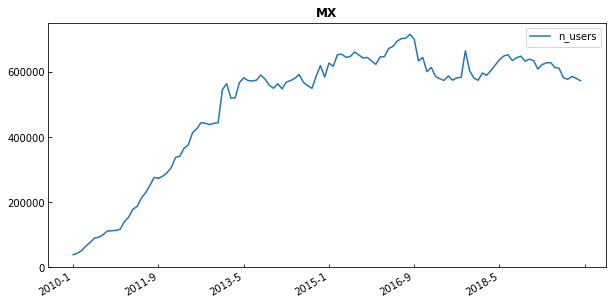

In [15]:
fig,ax=plt.subplots(figsize=(10,5))
df.plot(ax=ax,y='n_users',x='date',style='-',markersize=2)
ax.set_xlabel('')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
ax.set_title(country_code,fontweight='bold')
ax.locator_params(axis='y',nbins=5)
ax.set_ylim([0,df.n_users.max()*1.05])
fig.autofmt_xdate()

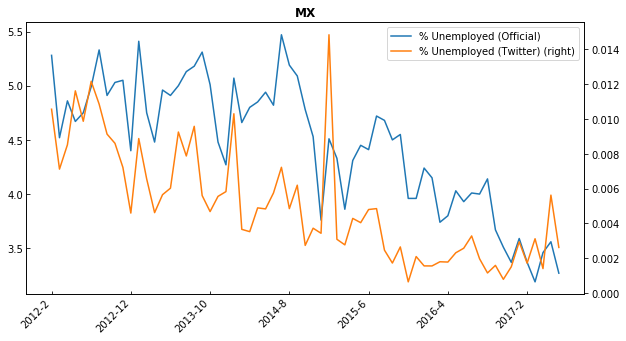

In [23]:
fig,ax=plt.subplots(figsize=(10,5))
df.iloc[25:90].plot(ax=ax,y='unemployment',x='date',label='% Unemployed (Official)')
df.iloc[25:90].plot(ax=ax,y='pct_search',secondary_y=True,x='date',label='% Unemployed (Twitter)')
ax.set_xlabel('')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
ax.set_title(country_code,fontweight='bold')
ax.locator_params(axis='y',nbins=6)
plt.savefig(os.path.join(path_to_data,'../'+country_code+'-agg.pdf'),bbox_inches='tight')

# County-level Estimates

In [18]:
# df=pd.merge(
# mentions,
# locations[
# ['user_location','administrative_area_level_1_short','administrative_area_level_2_long']
# ]).drop('user_location',1).rename(columns=lambda x:x.replace('_short','').replace('_long',''))

# df=df.groupby(['year','month','administrative_area_level_1','administrative_area_level_2'],as_index=False).sum()

# df.year=df.year.astype(int)
# df.month=df.month.astype(int)

# df=pd.merge(df,surveys.drop(['quarter','employed','urban_or_rural'],1),
# on=['year','month','administrative_area_level_1','administrative_area_level_2'])

# df.sort_values(by=['year','month'],inplace=True)